In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Model
#from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import ImageFont
from collections import defaultdict
from keras.utils import plot_model

2023-09-05 23:58:14.398492: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
image_size = (224,224,3)
model = InceptionV3(input_shape=image_size, include_top=False, weights='imagenet')

2023-09-05 23:58:16.336774: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-09-05 23:58:16.338059: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-09-05 23:58:16.373760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-05 23:58:16.373906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 104.43GiB/s
2023-09-05 23:58:16.373925: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-09-05 23:58:16.375656: I tensorflow/stream_executor/platform/def

In [3]:
for layers in model.layers:
    layers.trainable=False

In [4]:
arc = Model(inputs=model.input, outputs=Dense(2, activation="sigmoid")(Flatten()(model.output)))

In [5]:
train_path = "./COVID-19_Pneumonia/train"
validation_path = "./COVID-19_Pneumonia/val"
test_path = "./COVID-19_Pneumonia/test"

train_augmen=ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.3,horizontal_flip=True)
validation_augmen=ImageDataGenerator(rescale=1./255)
test_augmen=ImageDataGenerator(rescale=1./255)

final_train=train_augmen.flow_from_directory(train_path,target_size=(224,224))
step_size = len(final_train)
final_validation=validation_augmen.flow_from_directory(validation_path,target_size=(224,224))
final_test=test_augmen.flow_from_directory(test_path,target_size=(224,224))

Found 6397 images belonging to 2 classes.
Found 390 images belonging to 2 classes.
Found 308 images belonging to 2 classes.


In [6]:
initial_learning_rate = 0.00000005
def lr_schedule(epoch):
    if epoch < 200:
        return initial_learning_rate

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [7]:
arc.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
eff = arc.fit(final_train, epochs = 100, validation_data = final_validation, steps_per_epoch = len(final_train), validation_steps = len(final_validation), callbacks=[lr_callback])

Num GPUs Available:  1


2023-09-05 23:58:20.878194: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-09-05 23:58:20.896987: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499950000 Hz


Epoch 1/100


2023-09-05 23:58:25.863067: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-09-05 23:58:26.407149: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-09-05 23:58:27.231524: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-09-05 23:58:27.277677: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


200/200 [==============================] - 204s 880ms/step - loss: 0.7695 - accuracy: 0.5971 - precision: 0.6113 - recall: 0.4595 - val_loss: 0.8060 - val_accuracy: 0.5641 - val_precision: 0.5607 - val_recall: 0.4026
Epoch 2/100
200/200 [==============================] - 115s 575ms/step - loss: 0.7281 - accuracy: 0.6162 - precision: 0.6260 - recall: 0.4871 - val_loss: 0.7635 - val_accuracy: 0.5744 - val_precision: 0.5775 - val_recall: 0.4205
Epoch 3/100
200/200 [==============================] - 118s 590ms/step - loss: 0.6871 - accuracy: 0.6378 - precision: 0.6595 - recall: 0.5109 - val_loss: 0.7262 - val_accuracy: 0.6000 - val_precision: 0.6007 - val_recall: 0.4590
Epoch 4/100
200/200 [==============================] - 116s 579ms/step - loss: 0.6771 - accuracy: 0.6340 - precision: 0.6478 - recall: 0.5249 - val_loss: 0.6938 - val_accuracy: 0.6179 - val_precision: 0.6221 - val_recall: 0.4897
Epoch 5/100
200/200 [==============================] - 115s 575ms/step - loss: 0.6428 - accuracy

In [9]:
eva = arc.evaluate(final_test)
print(eva)

10/10 [==============================] - 27s 3s/step - loss: 0.1709 - accuracy: 0.9286 - precision: 0.9404 - recall: 0.9221
[0.1709337830543518, 0.9285714030265808, 0.940397322177887, 0.9220778942108154]


In [10]:
loss = eva[0]
accuracy = eva[1]
precision = eva[2]
recall = eva[3]
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Calculations are shown here\n")
print("Loss:",loss)
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1 score:",f1_score)

Calculations are shown here

Loss: 0.1709337830543518
Accuracy: 0.9285714030265808
Precision: 0.940397322177887
Recall: 0.9220778942108154
F1 score: 0.9311475126488944


In [11]:
#Verify results
test_loss, test_accuracy, test_precision, test_recall = arc.evaluate(final_test)
f1_score = 2 * ((test_precision * test_recall) / (test_precision + test_recall))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

10/10 [==============================] - 6s 620ms/step - loss: 0.1709 - accuracy: 0.9286 - precision: 0.9404 - recall: 0.9221
Test Loss: 0.17093373835086823
Test Accuracy: 0.9285714030265808
Test Precision: 0.940397322177887
Test Recall: 0.9220778942108154


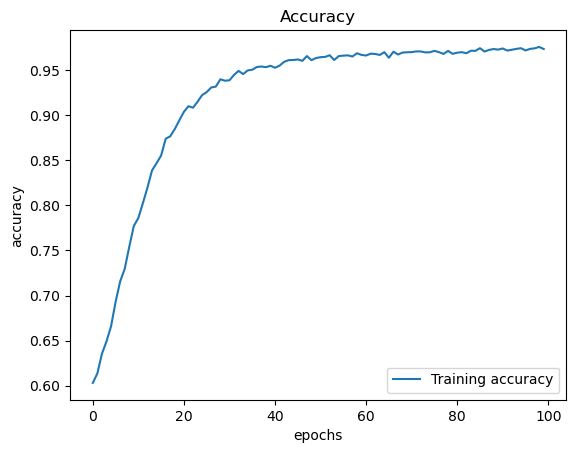

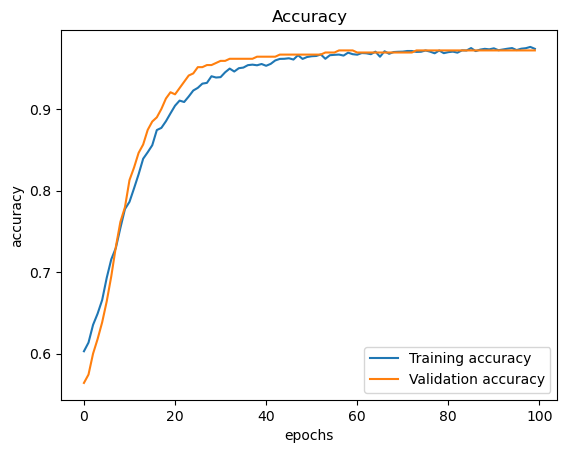

In [12]:
#Accuracy plot
plt.plot(eff.history['accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Training accuracy'], loc = 'lower right')
plt.show()

plt.plot(eff.history['accuracy'])
plt.plot(eff.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Training accuracy','Validation accuracy'], loc = 'lower right')
plt.show()

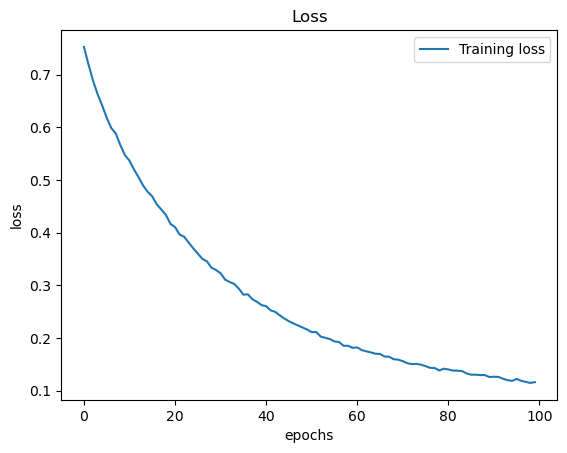

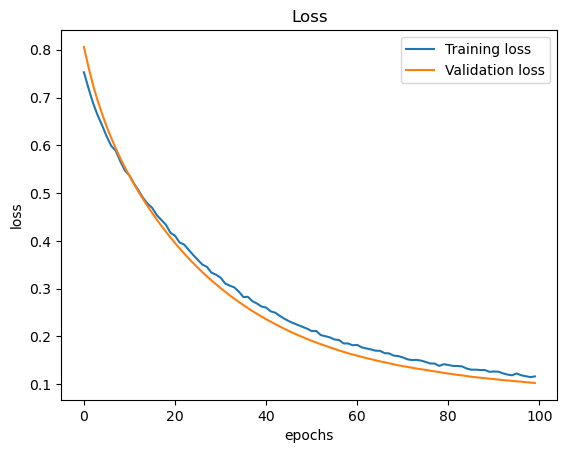

In [13]:
#Loss plot
plt.plot(eff.history['loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Training loss'], loc = 'upper right')
plt.show()

plt.plot(eff.history['loss'])
plt.plot(eff.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Training loss','Validation loss'], loc = 'upper right')
plt.show()

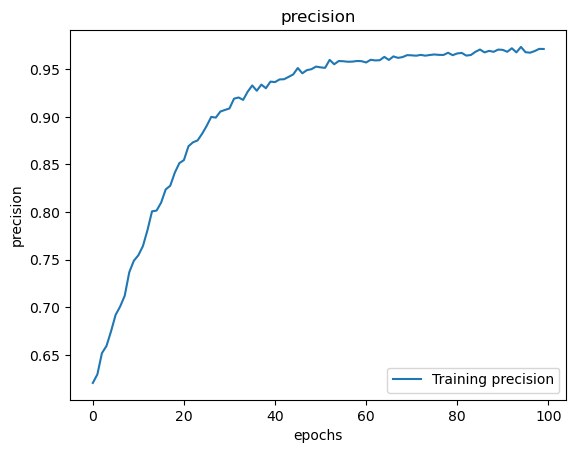

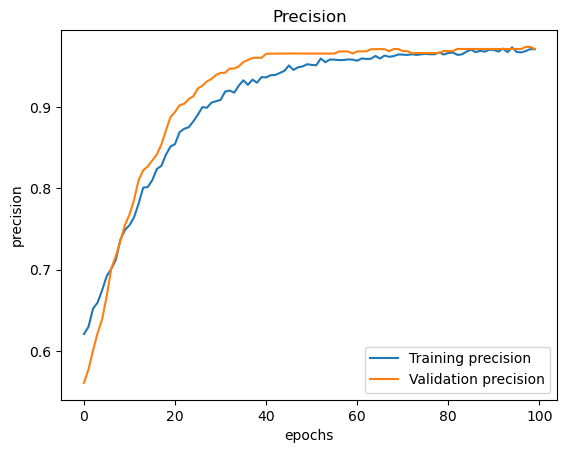

In [14]:
#Precision plot
plt.plot(eff.history['precision'])
plt.title('precision')
plt.ylabel('precision')
plt.xlabel('epochs')
plt.legend(['Training precision'], loc = 'lower right')
plt.show()


plt.plot(eff.history['precision'])
plt.plot(eff.history['val_precision'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epochs')
plt.legend(['Training precision','Validation precision'], loc = 'lower right')
plt.show()



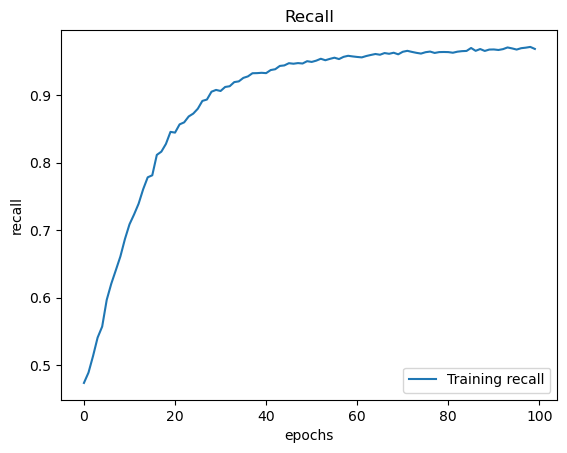

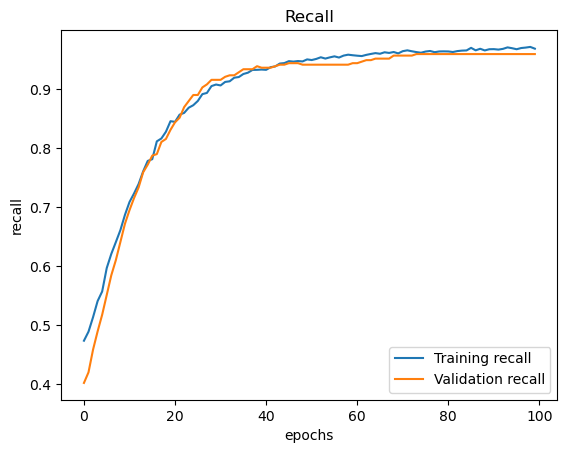

In [15]:
#Recall plot
plt.plot(eff.history['recall'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epochs')
plt.legend(['Training recall'], loc = 'lower right')
plt.show()

plt.plot(eff.history['recall'])
plt.plot(eff.history['val_recall'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epochs')
plt.legend(['Training recall','Validation recall'], loc = 'lower right')
plt.show()

In [16]:
arc.save('Ef.h5')

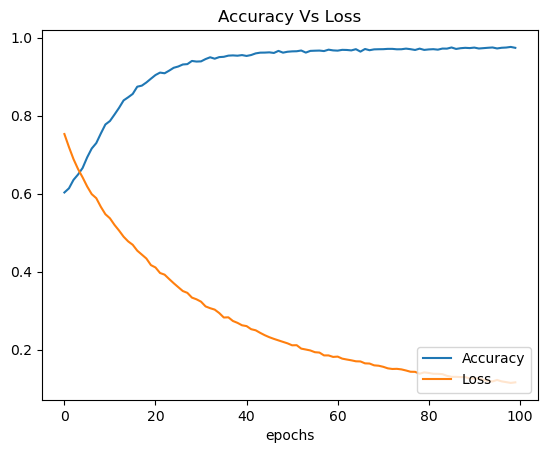

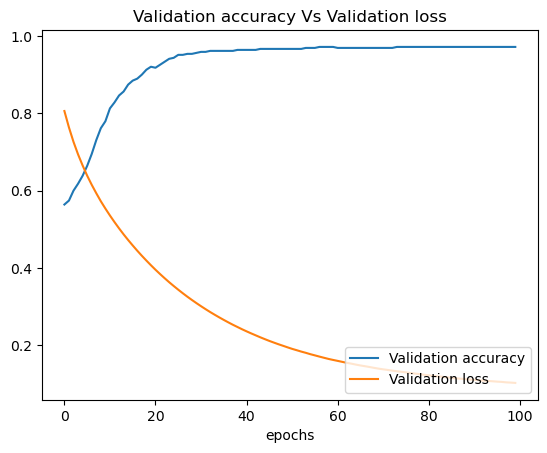

In [17]:
#Accuracy vs Loss plot
plt.plot(eff.history['accuracy'])
plt.plot(eff.history['loss'])
plt.title('Accuracy Vs Loss')
#plt.ylabel('accuracy vs loss')
plt.xlabel('epochs')
plt.legend(['Accuracy','Loss'], loc = 'lower right')
plt.show()

#Validation Accuracy vs Validation Loss plot
plt.plot(eff.history['val_accuracy'])
plt.plot(eff.history['val_loss'])
plt.title('Validation accuracy Vs Validation loss')
plt.xlabel('epochs')
plt.legend(['Validation accuracy','Validation loss'], loc = 'lower right')
plt.show()

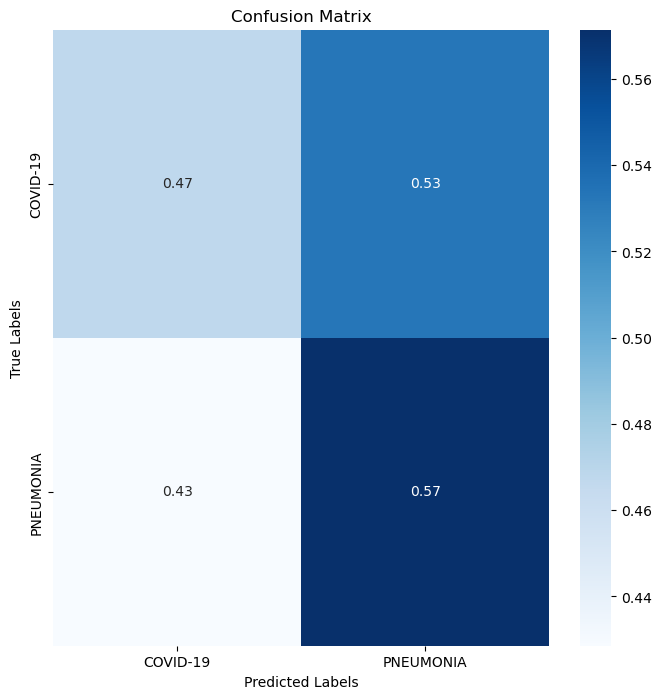

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = arc.predict(final_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = final_test.classes


cm = confusion_matrix(y_true, y_pred)

class_names = list(final_test.class_indices.keys())

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
